# Retail Location Intelligence Sample 

Azure Maps can be used by Retailers to better understand a location. Isochrones around the store location enable retailers to perform searches within the Isochrone to determine the demographic mix, parking spaces, parking spaces, competitors and other businesses that could potentially help drive traffic to for from the business.

In [20]:
import os
import json
import time
import requests
import urllib.parse
from IPython.display import Image, display

Load Subscription Key for Azure Maps from Config File 

In [21]:
config_file = 'config.json'
key = json.load(open(config_file))['key']
subscriptionKey = key

Westlake Center, considered Seattle's "town square", is a four-story shopping center in Downtown Seattle. Surrounding the mall, Seattle's main shopping district draws scores of both locals and visitors. We are looking at a 10min (600 sec) drive-time zone around Westlake Center for our Analysis. 

In [24]:
currentLocation = [47.6125983,-122.3379045]
driveTime = 600

Create an Isochrone around the Westlake Center using the Route Range API. This service will calculate a set of locations that can be reached from the origin point based on fuel, energy, or time budget that is specified. A polygon boundary (or Isochrone) is returned in a counterclockwise orientation as well as the precise polygon center which was the result of the origin point.

In [23]:
routeRangeResponse = requests.get("https://atlas.microsoft.com/route/range/json?subscription-key={}&api-version=1.0&query=47.6125983,-122.3379045&timeBudgetInSec=600".format(subscriptionKey)).json()

Define the boundary of the polygon around Westlake Center

In [25]:
polyBounds = routeRangeResponse["reachableRange"]["boundary"]


for i in range(len(polyBounds)):
    coordList = list(polyBounds[i].values())
    coordList[0], coordList[1] = coordList[1], coordList[0]
    polyBounds[i] = coordList

polyBounds.pop()
polyBounds.append(polyBounds[0])

boundsData = {
               "geometry": {
                 "type": "Polygon",
                 "coordinates": 
                   [
                      polyBounds
                   ]
                }
             }

Search for Starbucks in the Polygon around Westlake Center. You can edit this parameter to look for parking or any other entity.

In [26]:
searchPolyResponse = requests.post(url = "https://atlas.microsoft.com/search/geometry/json?subscription-key={}&api-version=1.0&query=starbucks&idxSet=POI&limit=50".format(subscriptionKey), json = boundsData).json()

reachableLocations = []
for loc in range(len(searchPolyResponse["results"])):
                location = list(searchPolyResponse["results"][loc]["position"].values())
                location[0], location[1] = location[1], location[0]
                reachableLocations.append(location)


In [16]:
rangeData = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          polyBounds
        ]
      }
    }
  ]
}

# Upload range data to Azure Maps data service.
# uploadRangeResponse = await session.post("https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = rangeData)

uploadRangeResponse = requests.post(url = "https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = rangeData)


rangeUdidRequest = uploadRangeResponse.headers["Location"]+"&subscription-key=tTk1JVEaeNvDkxxnxHm9cYaCvqlOq1u-fXTvyXn2XkA"

while True:
    getRangeUdid = requests.get(rangeUdidRequest).json()
    if 'udid' in getRangeUdid:
        break
    else:
        time.sleep(0.2)
rangeUdid = getRangeUdid["udid"]

In [17]:
poiData = {
    "type": "FeatureCollection",
    "features": [
      {
        "type": "Feature",
        "properties": {},
        "geometry": {
            "type": "MultiPoint",
            "coordinates": reachableLocations
        }
    }
  ]
}

# Upload EV charging stations data to Azure Maps data service.
#uploadPOIsResponse = await session.post("https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = poiData)
uploadPOIsResponse = requests.post(url = "https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = poiData)

poiUdidRequest = uploadPOIsResponse.headers["Location"]+"&subscription-key=tTk1JVEaeNvDkxxnxHm9cYaCvqlOq1u-fXTvyXn2XkA"

while True:
    getPoiUdid = requests.get(poiUdidRequest).json()
    if 'udid' in getPoiUdid:
        break
    else:
        time.sleep(0.2)
poiUdid = getPoiUdid["udid"]

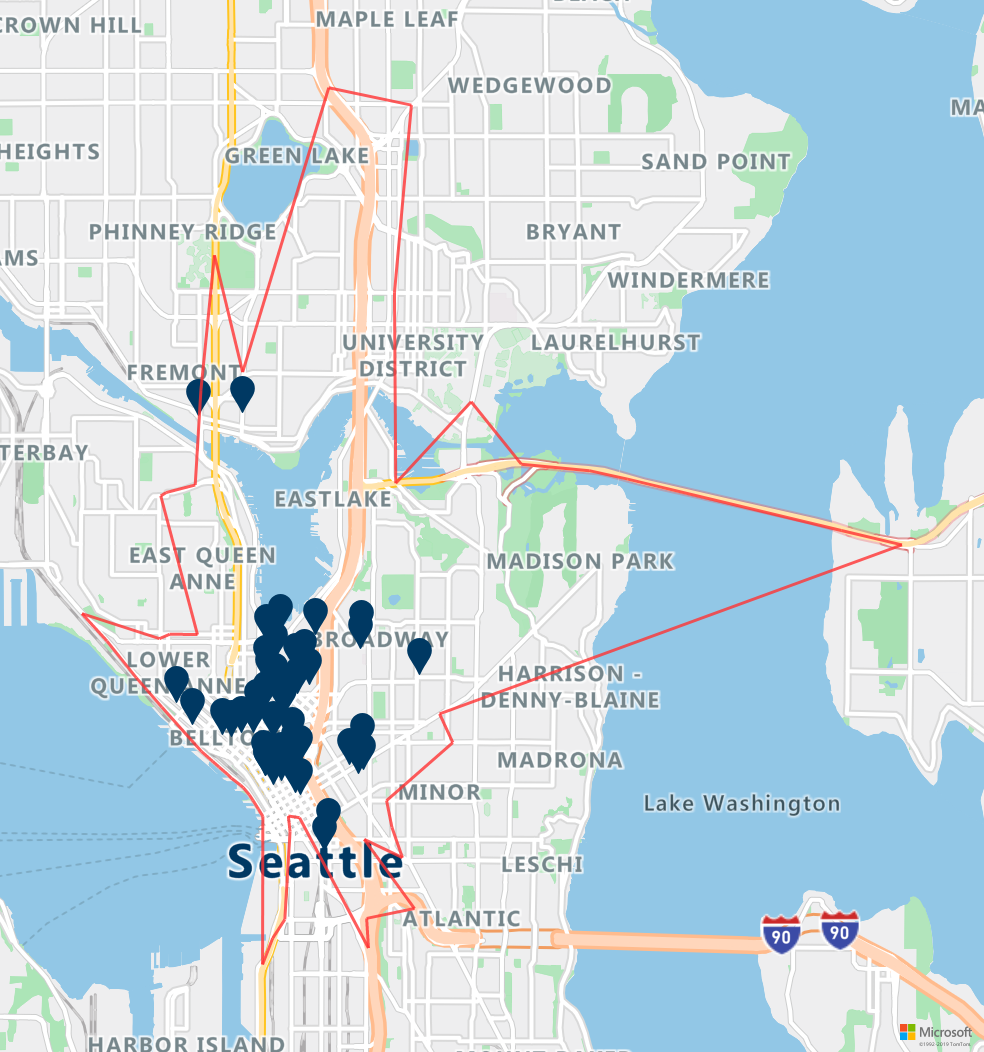

In [18]:
# Get bounds for bounding box.
def getBounds(polyBounds):
    maxLon = max(map(lambda x: x[0], polyBounds))
    minLon = min(map(lambda x: x[0], polyBounds))

    maxLat = max(map(lambda x: x[1], polyBounds))
    minLat = min(map(lambda x: x[1], polyBounds))
    
    # Buffer the bounding box by 10% to account for the pixel size of pins at the ends of the route.
    lonBuffer = (maxLon-minLon)*0.1
    minLon -= lonBuffer
    maxLon += lonBuffer

    latBuffer = (maxLat-minLat)*0.1
    minLat -= latBuffer
    maxLat += latBuffer
    
    return [minLon, maxLon, minLat, maxLat]

minLon, maxLon, minLat, maxLat = getBounds(polyBounds)

path = "lcff3333|lw3|la0.80|fa0.35||udid-{}".format(rangeUdid)
#pins = "custom|an15 53||udid-{}||https://cdn4.iconfinder.com/data/icons/Starbucks_coffee/PNG/512x512/starbucks_coffee_1.png".format(poiUdid)
pins = "default|an15 53||udid-{}".format(poiUdid)

encodedPins = urllib.parse.quote(pins, safe='')

# Render range and EV charging points on the map.
# staticMapResponse =  await session.get("https://atlas.microsoft.com/map/static/png?api-version=1.0&subscription-key={}&pins={}&path={}&bbox={}&zoom=12".format(subscriptionKey,encodedPins,path,str(minLon)+", "+str(minLat)+", "+str(maxLon)+", "+str(maxLat)))


staticMapResponse = requests.get("https://atlas.microsoft.com/map/static/png?api-version=1.0&subscription-key={}&pins={}&path={}&bbox={}&zoom=12".format(subscriptionKey,encodedPins,path,str(minLon)+", "+str(minLat)+", "+str(maxLon)+", "+str(maxLat)))


#poiRangeMap = await staticMapResponse.content.read()
poiRangeMap = staticMapResponse.content

display(Image(poiRangeMap))
